In [58]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [59]:
def Ground_Update(cur_state,wl,wr,t):
    next_state=np.zeros((3,1))
    
    speed_std=130*0.05*2*np.pi/60
    nwl=np.random.normal(0,speed_std)
    nwr=np.random.normal(0,speed_std)
    next_state[0]=cur_state[0][0]+20*t*(wl+nwl-wr-nwr)/85
    next_state[1]=cur_state[1][0]+((wl+nwl)*20*t+(wr+nwr)*20*t)/2*math.sin(cur_state[0][0])
    next_state[2]=cur_state[2][0]+((wl+nwl)*20*t+(wr+nwr)*20*t)/2*math.cos(cur_state[0][0])
    return next_state
    

In [60]:
def Time_Update(cur_state,wl,wr,t,cur_cov):
    next_state=np.zeros((3,1))
    next_cov=np.zeros((3,3))
    
    #mean update
    vt=(wl*20*t+wr*20*t)/2
    next_state[0]=cur_state[0][0]+20*t*(wl-wr)/85
    next_state[1]=cur_state[1][0]+vt*math.sin(cur_state[0][0])
    next_state[2]=cur_state[2][0]+vt*math.cos(cur_state[0][0])
    
    #linearization
    speed_std=130*0.05*2*np.pi/60
    Ft=np.array([[1,0,0],[-vt*math.sin(cur_state[0][0]),1,0],[vt*math.cos(cur_state[0][0]),0,1]])
    Wt=np.array([[t,0],[0,math.cos(cur_state[0][0])*t],[0,math.sin(cur_state[0][0])*t]])
    Q=np.array([[speed_std**2, 0], [0, speed_std**2]])
    
    #covariance update
    next_cov=np.dot(np.dot(Ft,cur_cov),Ft.T)+np.dot(np.dot(Wt,Q),Wt.T)
    
    return next_state,next_cov
    

In [225]:
def Observation_Update(cur_state,cur_cov):
    df=0
    dr=0
    next_state=np.zeros((3,1))
    next_cov=np.zeros((3,3))
    yt=np.zeros((3,1))
    
    theta=cur_state[0][0]
    x=cur_state[1][0]
    y=cur_state[2][0]
    o=theta
    
    d_std=500*0.03
    ndf=np.random.normal(0,d_std)
    ndr=np.random.normal(0,d_std)
    o_std=np.radians(0.1)
    no=np.random.normal(0,o_std)
    
    H=np.zeros((3,3))
    
    #Observation of df dr from x y theta
    if 0<=o<np.pi/2:
        if (500-y)*np.tan(o)>(750-x):
            df=(750-x)/np.sin(o)
            H[0]=np.array([-(750-x)*np.cos(o)/np.sin(o)**2,-1/np.sin(o),0])
        else:
            df=(500-y)/np.cos(o)
            H[0]=np.array([(500-y)*np.sin(o)/np.cos(o)**2,0,-1/np.cos(o)])
            
        if y/np.tan(o)>(750-x):
            dr=(750-x)/np.cos(o)
            H[1]=np.array([(750-x)*np.sin(o)/np.cos(o)**2,-1/np.cos(o),0])
        else:
            dr=y/np.sin(o)
            H[1]=np.array([-y*np.cos(o)/np.sin(o)**2,0,1/np.sin(o)])
        
    elif np.pi/2<=o<np.pi:
        o=o-np.pi/2
        if y/np.tan(o)>(750-x):
            df=(750-x)/np.cos(o)
            H[0]=np.array([(750-x)*np.sin(o)/np.cos(o)**2,-1/np.cos(o),0])
        else:
            df=y/np.sin(o)
            H[0]=np.array([-y*np.cos(o)/np.sin(o)**2,0,1/np.sin(o)])
            
        if y*np.tan(o)<x:
            dr=y/np.cos(o)
            H[1]=np.array([y*np.sin(o)/np.cos(o)**2,0,1/np.cos(o)])
        else:
            dr=x/np.sin(o)
            H[1]=np.array([-x*np.cos(o)/np.sin(o)**2,1/np.sin(o),0])
            
    elif np.pi<=o<3*np.pi/2:
        o=o-np.pi
        if y*np.tan(o)<x:
            df=y/np.cos(o)
            H[0]=np.array([y*np.sin(o)/np.cos(o)**2,0,1/np.cos(o)])
        else:
            df=x/np.sin(o)
            H[0]=np.array([-x*np.cos(o)/np.sin(o)**2,1/np.sin(o),0])
            
        if x*np.tan(o)>(500-y):
            dr=(500-y)/np.sin(o)
            H[1]=np.array([-(500-y)*np.cos(o)/np.sin(o)**2,0,-1/np.sin(o)])
        else:
            dr=x/np.cos(o)
            H[1]=np.array([x*np.sin(o)/np.cos(o)**2,1/np.cos(o),0])
            
    elif 3*np.pi/2<=o<2*np.pi:
        if x*np.tan(o)>(500-y):
            df=(500-y)/np.sin(o)
            H[0]=np.array([-(500-y)*np.cos(o)/np.sin(o)**2,0,-1/np.sin(o)])
        else:
            df=x/np.cos(o)
            H[0]=np.array([x*np.sin(o)/np.cos(o)**2,1/np.cos(o),0])
            
        if (500-y)*np.tan(o)>(750-x):
            dr=(750-x)/np.sin(o)
            H[1]=np.array([-(750-x)*np.cos(o)/np.sin(o)**2,-1/np.sin(o),0])
        else:
            dr=(500-y)/np.cos(o)
            H[1]=np.array([(500-y)*np.sin(o)/np.cos(o)**2,0,-1/np.cos(o)])
            
    yt[0][0]=df+ndf
    yt[1][0]=dr+ndr
    yt[2][0]=theta+no

    H[2]=np.array([1,0,0])
    R = np.diag([d_std**2,d_std**2,o_std**2])
    
    #Observation update
    Hv=np.linalg.inv(np.dot(np.dot(H,cur_cov),H.T)+R)
    next_state=cur_state+np.dot(np.dot(np.dot(cur_cov,H.T),Hv),(yt-np.dot(H,cur_state)))
    next_cov=cur_cov-np.dot(np.dot(np.dot(cur_cov,H.T),Hv),np.dot(H,cur_cov))

    return next_state,next_cov

D:\UCLA\Anaconda\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in double_scalars


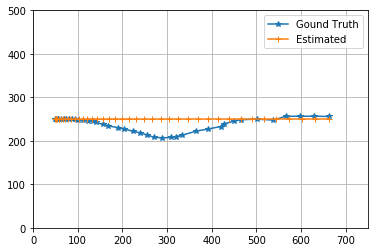

In [270]:
si=[[np.pi/2],[50],[250]]
ci=[[np.radians(1),0,0],[0,1,0],[0,0,1]]
x_t=[]
y_t=[]
x_t_e=[]
y_t_e=[]
x_c=[]
y_c=[]
s=si
c=ci
se=si
ce=ci
se1=si

for i in range(40):
    t=i/40
    s=Ground_Update(s,np.pi/2,np.pi/2,t)
    x_t.append(s[1])
    y_t.append(s[2])
    
    [se,ce]=Time_Update(se,np.pi/2,np.pi/2,t,ce)

    [se1,ce]=Observation_Update(se,ce)
    x_t_e.append(se[1])
    y_t_e.append(se[2])
    x_c.append(ce[1][1])
    y_c.append(ce[2][2])

#plot mean path
plt.figure()
plt.grid(True)
plt.xlim((0, 750))
plt.ylim((0, 500))
plt.plot(x_t, y_t, marker='*')
plt.plot(x_t_e, y_t_e, marker='+')
plt.legend(['Gound Truth', 'Estimated'])
plt.show()

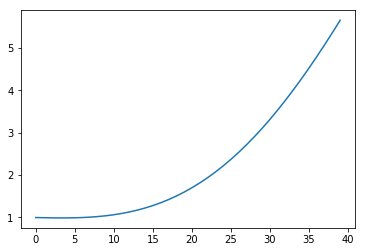

In [271]:
plt.plot(y_c)

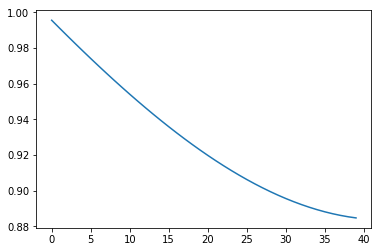

In [272]:
plt.plot(x_c)

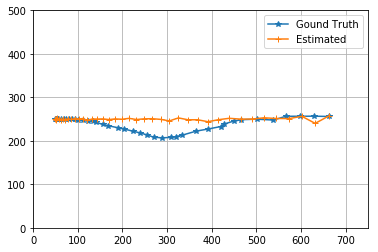

In [273]:
#plot path
x_e=np.zeros((40,1))
y_e=np.zeros((40,1))
for i in range(40):
    x_e[i]=np.random.normal(x_t_e[i],0)
    y_e[i]=np.random.normal(y_t_e[i],y_c[i])
    
plt.figure()
plt.grid(True)
plt.xlim((0, 750))
plt.ylim((0, 500))

plt.plot(x_t, y_t, marker='*')
plt.plot(x_e, y_e, marker='+')
plt.legend(['Gound Truth', 'Estimated'])
plt.show()